## Importing The Relevant Packages

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from google.colab import drive
from scipy.stats.distributions import chi2

sns.set()

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


## Importing Data and Pre-Processing

In [4]:
raw_csv_data = pd.read_csv("/content/drive/MyDrive/Formations/Time Series/Index2018.csv", index_col="date", parse_dates=True, dayfirst=True)
df_comp = raw_csv_data.copy()
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")

In [5]:
df_comp["market_value"] = df_comp.ftse

In [6]:
df_comp.drop(columns=["spx", "dax", "ftse", "nikkei"], inplace=True)
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp[size:]

## The ACF

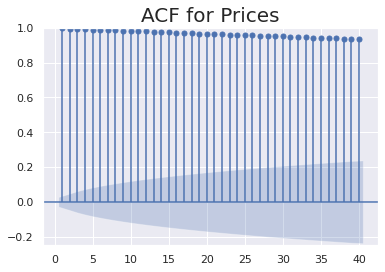

In [7]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title("ACF for Prices", size=20)
plt.ylim(-0.25, 1)
plt.show()

## The PACF
* Coefficients of different size (not all between $0.9$ and $1$).
* Coefficients that are negative.
* Coefficients which are not significant.
* We ignore the coefficients in which their blue areas are nearer.
* Coefficient values will be extremly close to $0$.
* Their impact on the model minimal, so they are not relevant to us.
* Our model is likely to include less than $25$ lags.
* The frequency of the data is in business days and there are roughly $22$ business days in a month, we can anticipate some cyclical changes every month. In other words, the values a month ago negatively affect the values today.
* The coefficient of the first lag is significantly high, so, we won't include it in our model.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


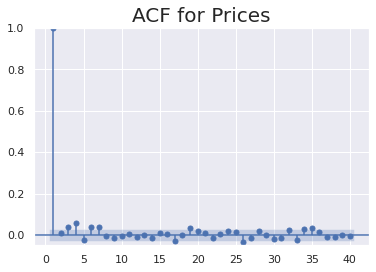

In [8]:
sgt.plot_pacf(df.market_value, zero=False, lags=40)
plt.title("ACF for Prices", size=20)
plt.ylim(-0.05, 1)
plt.show()

## The AR(1) Model
In the context of ARIMA models, "order" refers to the parameters of the model that determine the behavior of the autoregressive (AR) and moving average (MA) components. The order is usually represented as a tuple `(p, d, q)`, where:

* `p`: the order of the autoregressive (AR) component, which is the number of lagged values of the dependent variable to include in the model
* `d`: the degree of differencing, which is the number of times the data needs to be differenced to make it stationary
* `q`: the order of the moving average (MA) component, which is the number of lagged forecast errors to include in the model

* Here, we used a simple $AR(1)$ model
* The standard error measures how far away, on average, the model's predicitions are from the true values.
* $z$ column represents the associated test-statistics for significance.



In [9]:
model_ar = ARIMA(df.market_value, order=(1, 0, 0))

In [10]:
results_ar = model_ar.fit()

In [11]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Sun, 26 Mar 2023   AIC                          55251.207
Time:                        11:10:48   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6374    423.329     12.023      0.000    4259.929    5919.346
ar.L1          0.9984      0.001   1147.578      0.000       0.997       1.000
sigma2      3511.3841     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher Lag AR-Models

* The coefficient `ar.L2` is greater than $\alpha=0.05$, thus, it doesn't the prices two days ago don't affect prices today. In other words, this effect is captured in yesterday's price
* We prefer models with high **Log-Likelihood** and lower **Information criterion**

In [12]:
model_ar_2 = ARIMA(df.market_value, order=(2, 0, 0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -27621.949
Date:                Sun, 26 Mar 2023   AIC                          55251.898
Time:                        11:10:53   BIC                          55277.984
Sample:                    01-07-1994   HQIC                         55261.039
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    368.251     13.821      0.000    4367.881    5811.400
ar.L1          0.9811      0.010     99.868      0.000       0.962       1.000
ar.L2          0.0171      0.010      1.749      0.080      -0.002       0.036
sigma2      3510.1277     41.037     85.535      0.000    3429.696    3590.560
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3282.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model_ar_3 = ARIMA(df.market_value, order=(3, 0, 0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27615.962
Date:                Sun, 26 Mar 2023   AIC                          55241.925
Time:                        11:10:56   BIC                          55274.532
Sample:                    01-07-1994   HQIC                         55253.351
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    378.583     13.444      0.000    4347.631    5831.651
ar.L1          0.9802      0.010     99.076      0.000       0.961       1.000
ar.L2         -0.0309      0.013     -2.315      0.021      -0.057      -0.005
ar.L3          0.0489      0.009      5.383      0.000       0.031       0.067
sigma2      3502.2643     41.020     85.379      0.000    3421.866    3582.662
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3286.97
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model_ar_4 = ARIMA(df.market_value, order=(4, 0, 0))
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27602.680
Date:                Sun, 26 Mar 2023   AIC                          55217.359
Time:                        11:11:09   BIC                          55256.488
Sample:                    01-07-1994   HQIC                         55231.070
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    391.960     12.985      0.000    4321.414    5857.868
ar.L1          0.9767      0.010     97.788      0.000       0.957       0.996
ar.L2         -0.0287      0.013     -2.129      0.033      -0.055      -0.002
ar.L3         -0.0224      0.013     -1.784      0.074      -0.047       0.002
ar.L4          0.0728      0.009      8.033      0.000       0.055       0.091
sigma2      3484.0262     41.922     83.108      0.000    3401.861    3566.191
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3044.18
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## LLR Test

In [16]:
"""mod_1, mod_2 : models we want to compare
DF : degrees of freedom"""
def LLR_test(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf 
  L2 = mod_2.fit().llf
  LR = 2*(L2-L1) 
  p = chi2.sf(LR, DF).round(3)
  return p

## Comparing Higher-Lag AR Models
* The difference is significant, this suggests, we opt for complicated model `model_ar_3`.
* We can continue fitting more complicated model and checking if it gives us distinguishably greater Log-Likelihoods, until we reach a model where it doesn't. Moreover, the said model should also have the last lag not be significantly different from $0$ ($\approx0$).

In [18]:
LLR_test(model_ar_2, model_ar_3)

0.001

In [19]:
LLR_test(model_ar_3, model_ar_4)

0.0

In [21]:
model_ar_4 = ARIMA(df.market_value, order=(4, 0, 0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("LLR test" + str(LLR_test(model_ar_3, model_ar_4)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27602.680
Date:                Sun, 26 Mar 2023   AIC                          55217.359
Time:                        11:35:26   BIC                          55256.488
Sample:                    01-07-1994   HQIC                         55231.070
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    391.960     12.985      0.000    4321.414    5857.868
ar.L1          0.9767      0.010     97.788      0.000       0.957       0.996
ar.L2         -0.0287      0.013     -2.129      0.0

In [26]:
model_ar_5 = ARIMA(df.market_value, order=(5, 0, 0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("LLR test " + str(LLR_test(model_ar_4, model_ar_5)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -27600.460
Date:                Sun, 26 Mar 2023   AIC                          55214.920
Time:                        11:37:53   BIC                          55260.570
Sample:                    01-07-1994   HQIC                         55230.916
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    386.229     13.178      0.000    4332.646    5846.636
ar.L1          0.9788      0.010     97.867      0.000       0.959       0.998
ar.L2         -0.0293      0.013     -2.176      0.0

In [28]:
model_ar_6 = ARIMA(df.market_value, order=(6, 0, 0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("LLR test " + str(LLR_test(model_ar_5, model_ar_6)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 0)   Log Likelihood              -27596.587
Date:                Sun, 26 Mar 2023   AIC                          55209.174
Time:                        11:38:14   BIC                          55261.345
Sample:                    01-07-1994   HQIC                         55227.455
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    396.931     12.822      0.000    4311.670    5867.612
ar.L1          0.9800      0.010     96.873      0.000       0.960       1.000
ar.L2         -0.0333      0.014     -2.438      0.0

In [29]:
model_ar_7 = ARIMA(df.market_value, order=(7, 0, 0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("LLR test " + str(LLR_test(model_ar_6, model_ar_7)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -27592.022
Date:                Sun, 26 Mar 2023   AIC                          55202.044
Time:                        11:39:35   BIC                          55260.736
Sample:                    01-07-1994   HQIC                         55222.610
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    405.380     12.555      0.000    4295.111    5884.171
ar.L1          0.9783      0.010     95.742      0.000       0.958       0.998
ar.L2         -0.0304      0.014     -2.183      0.0

1. Non-significant p-value for the LLR test.
2. Non-significant p-value for the highest lag coefficients

In [30]:
model_ar_8 = ARIMA(df.market_value, order=(8, 0, 0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("LLR test " + str(LLR_test(model_ar_7, model_ar_8)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -27591.854
Date:                Sun, 26 Mar 2023   AIC                          55203.708
Time:                        11:41:27   BIC                          55268.922
Sample:                    01-07-1994   HQIC                         55226.560
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    407.242     12.498      0.000    4291.460    5887.821
ar.L1          0.9787      0.010     95.719      0.000       0.959       0.999
ar.L2         -0.0305      0.014     -2.183      0.0

In [31]:
print("LLR test " + str(LLR_test(model_ar, model_ar_7, DF=6)))

LLR test 0.0


## The DF-Test

* Extracted from non-stationary process
* We shouldn't rely on AR models to make accurate forecasts
* Solution : Transforming the data set, so that it fits the "stationary" assumptions

In [32]:
sts.adfuller(df.market_value)

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

## Using Returns
The pourcentage between returns (the values for two consecutive periods).

* Create returns out of prices $\frac{P_t-P_{t-1}}{P_{t-1}}$

In [35]:
df["returns"] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

<ipython-input-35-99e1d5c5b537>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df.market_value.pct_change(1).mul(100)


* Our statistic test is lower than even the $1\%$ critical value.
* We can conclude that our data comes from stationary process

In [36]:
sts.adfuller(df.returns)

(-12.770265719497264,
 7.798058336037375e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.7672456975)

## ACF and PACF for Returns

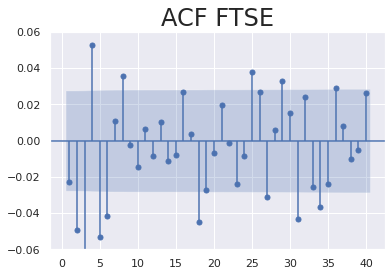

In [40]:
sgt.plot_acf(df.returns, lags=40, zero=False)
plt.title("ACF FTSE", size=24)
plt.ylim(-0.06, 0.06)
plt.show()


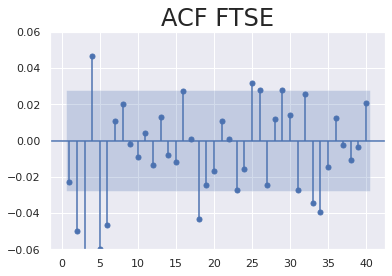

In [41]:
sgt.plot_pacf(df.returns, lags=40, zero=False, method=('ols'))
plt.title("ACF FTSE", size=24)
plt.ylim(-0.06, 0.06)
plt.show()

## AR(1) for Returns

In [43]:
model_ret_ar_1 = ARIMA(df.returns, order=(1, 0, 0))

In [44]:
results_ret_ar_1 = model_ret_ar_1.fit()

* Neither is significantly different from 0
* This model holds no real predictive power
* This can be explained by the impact pas values can have on yesterday's prices
* The more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes.

In [45]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Sun, 26 Mar 2023   AIC                          15865.497
Time:                        12:42:37   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag AR Models for Returns

* The p-value for the last coefficient is $0$. This means that $\phi_2$ is significantly different from $0$.

In [46]:
model_ret_ar_2 = ARIMA(df.returns, order=(2, 0, 0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.456
Date:                Sun, 26 Mar 2023   AIC                          15854.911
Time:                        12:46:51   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.233      -0.012       0.050
ar.L1         -0.0242      0.009     -2.799      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.371      0.000      -0.065      -0.035
sigma2         1.3756      0.014     99.592      0.000       1.348       1.403
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7730.29
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$AR(2)$>$AR(1)$

In [47]:
LLR_test(model_ret_ar_1, model_ret_ar_2)

0.0

* Since the p-value for the newest coefficient is better, we expect the LLR test to suggest that this model is better than the previous one.

In [48]:
model_ret_ar_3 = ARIMA(df.returns, order=(3, 0, 0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7906.738
Date:                Sun, 26 Mar 2023   AIC                          15823.477
Time:                        12:51:49   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.272      0.203      -0.010       0.048
ar.L1         -0.0283      0.009     -3.199      0.001      -0.046      -0.011
ar.L2         -0.0521      0.008     -6.684      0.000      -0.067      -0.037
ar.L3         -0.0815      0.008    -10.192      0.000      -0.097      -0.066
sigma2         1.3664      0.014     94.518      0.000       1.338       1.395
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              6859.16
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
LLR_test(model_ret_ar_2, model_ret_ar_3)

0.0

In [55]:
model_ret_ar_4 = ARIMA(df.returns, order=(4, 0, 0))
results_ret_ar_4 = model_ret_ar_4.fit()
print(results_ret_ar_4.summary())
print("LLR test " + str(LLR_test(model_ret_ar_3, model_ret_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7901.330
Date:                Sun, 26 Mar 2023   AIC                          15814.661
Time:                        12:59:17   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0245      0.009     -2.770      0.006      -0.042      -0.007
ar.L2         -0.0496      0.008     -6.327      0.0

In [56]:
model_ret_ar_5 = ARIMA(df.returns, order=(5, 0, 0))
results_ret_ar_5 = model_ret_ar_5.fit()
print(results_ret_ar_5.summary())
print("LLR test " + str(LLR_test(model_ret_ar_4, model_ret_ar_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7892.390
Date:                Sun, 26 Mar 2023   AIC                          15798.779
Time:                        12:59:42   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0217      0.009     -2.396      0.017      -0.040      -0.004
ar.L2         -0.0544      0.008     -6.826      0.0

In [57]:
model_ret_ar_6 = ARIMA(df.returns, order=(6, 0, 0))
results_ret_ar_6 = model_ret_ar_6.fit()
print(results_ret_ar_6.summary())
print("LLR test " + str(LLR_test(model_ret_ar_5, model_ret_ar_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Sun, 26 Mar 2023   AIC                          15789.890
Time:                        13:00:08   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.0

In [58]:
model_ret_ar_7 = ARIMA(df.returns, order=(7, 0, 0))
results_ret_ar_7 = model_ret_ar_7.fit()
print(results_ret_ar_7.summary())
print("LLR test " + str(LLR_test(model_ret_ar_6, model_ret_ar_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7886.647
Date:                Sun, 26 Mar 2023   AIC                          15791.294
Time:                        13:00:49   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.304      0.192      -0.010       0.047
ar.L1         -0.0240      0.009     -2.579      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.375      0.0

## Normalizing
* Normalizing does not affect stationarity

In [59]:
benchmark = df.market_value.iloc[0]

In [61]:
df["norm"] = df.market_value.div(benchmark).mul(100)

In [62]:
sts.adfuller(df.norm)

(-1.8928710132672355,
 0.335422207433007,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

In [63]:
bench_ret = df.returns.iloc[0]
df["norm_ret"] = df.returns.div(bench_ret).mul(100)

In [64]:
sts.adfuller(df.norm_ret)

(-12.770265719497267,
 7.798058336037155e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

## Normalizing returns
* We often rely on normalized returns
* They account for the absolute profitability of the investment in constrast to prices
* They allow us to compare the relative profitability as opposed to non-normalized returns
* The normalization has affect on constant and no for any lag coefficient
* The same model that failed for regular returns would also fail for normalized returns

In [66]:
model_norm_ret_ar_1 = ARIMA(df.norm_ret, order=(1, 0, 0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -40351.743
Date:                Sun, 26 Mar 2023   AIC                          80709.487
Time:                        13:16:51   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.476     -1.143      0.253     -32.506       8.560
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2      5.617e+05   5612.960    100.071      0.000    5.51e+05    5.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
model_norm_ret_ar_2 = ARIMA(df.norm_ret, order=(2, 0, 0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -40345.450
Date:                Sun, 26 Mar 2023   AIC                          80698.901
Time:                        13:18:46   BIC                          80724.986
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.050     -1.191      0.234     -31.671       7.725
ar.L1         -0.0242      0.009     -2.797      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.368      0.000      -0.065      -0.035
sigma2      5.603e+05   5628.139     99.561      0.000    5.49e+05    5.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7730.40
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
model_norm_ret_ar_7 = ARIMA(df.norm_ret, order=(7, 0, 0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -40308.642
Date:                Sun, 26 Mar 2023   AIC                          80635.285
Time:                        13:21:06   BIC                          80693.975
Sample:                    01-10-1994   HQIC                         80655.851
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731      9.262     -1.293      0.196     -30.126       6.179
ar.L1         -0.0240      0.009     -2.577      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.370      0.000      -0.068      -0.036
ar.L3         -0.0874      0.008    -10.717      0.000      -0.103      -0.071
ar.L4          0.0433      0.008      5.178      0.000       0.027       0.060
ar.L5         -0.0601      0.008     -7.457      0.000      -0.076      -0.044
ar.L6         -0.0463      0.009     -5.169      0.000      -0.064      -0.029
ar.L7          0.0109      0.009      1.204      0.228      -0.007       0.029
sigma2      5.524e+05   6023.895     91.707      0.000    5.41e+05    5.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6448.21
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Analysing the Residuals
* The mean is approximately $0$, which suggests that on average our model performs well.
* The high variance indicates the residuals are not concentrated on the mean (zero). It's normal since it's not stationary.

In [69]:
df["res_price"] = results_ar_7.resid

In [70]:
df.res_price.mean()

0.3522785798857139

In [71]:
df.res_price.var()

4010.358058670474

In [72]:
sts.adfuller(df.res_price)

(-75.94771893784434,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 54832.16530984672)

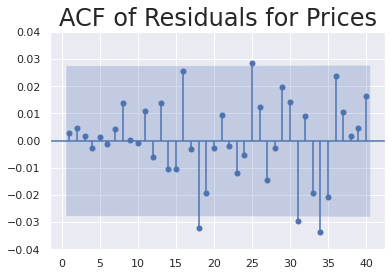

In [78]:
sgt.plot_acf(df.res_price, zero = False, lags= 40)
plt.title("ACF of Residuals for Prices", size = 24)
plt.ylim(-0.04, 0.04)
plt.show()

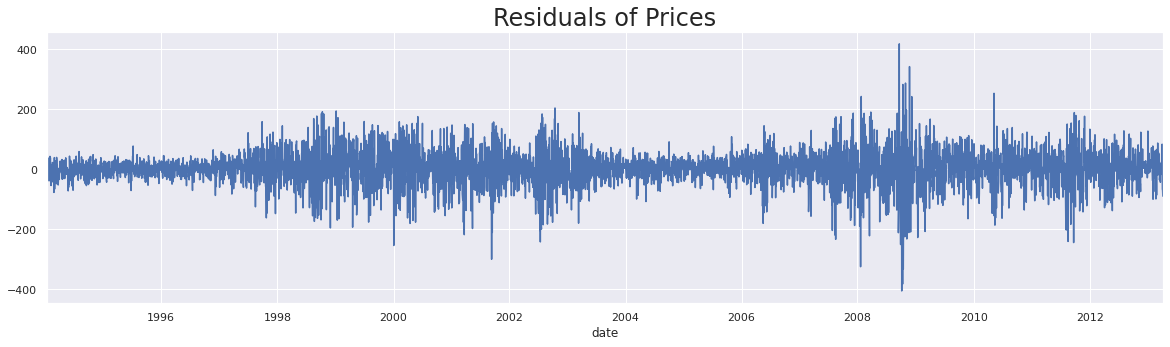

In [79]:
df.res_price[1:].plot(figsize=(20, 5))
plt.title("Residuals of Prices", size=24)
plt.show()

## Analysing the Residuals for returns

$res ∼ N(0, 1)$

In [80]:
df['res_ret'] = results_ret_ar_6.resid

In [81]:
df.res_ret.mean()

-4.8530457550453984e-05

In [82]:
df.res_ret.var()

1.355980212871522

In [83]:
sts.adfuller(df.res_ret)

(-70.78411835964063,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570807333253)

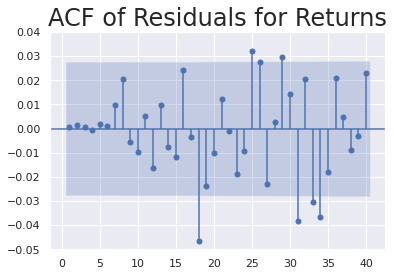

In [85]:
sgt.plot_acf(df.res_ret, zero = False, lags= 40)
plt.title("ACF of Residuals for Returns", size = 24)
plt.ylim(-0.05, 0.04)
plt.show()

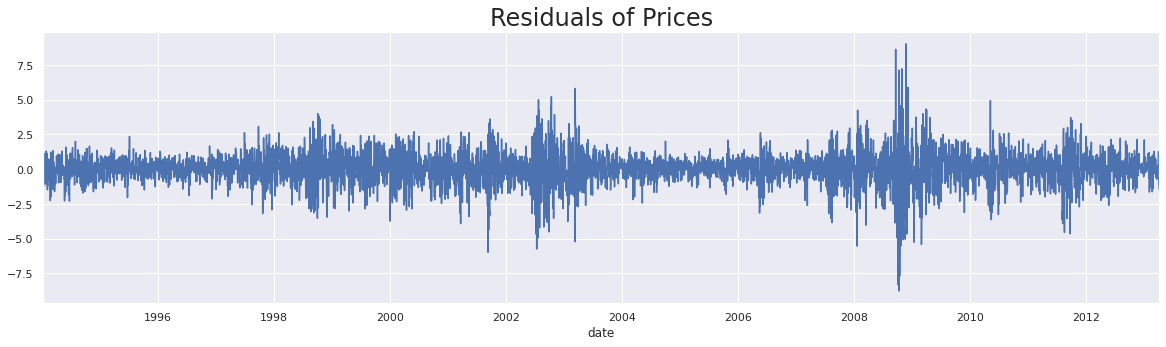

In [86]:
df.res_ret[1:].plot(figsize=(20, 5))
plt.title("Residuals of Prices", size=24)
plt.show()